In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Medical Image Classification Lab: Cervical Curvature Types with ResNet50 - Training, Evaluation & Explaination

## Dataset source and citation

The X-ray images and curvature labels used in this notebook come from the **Cervical Spine X-ray Atlas (CSXA)** introduced by Ran et al. (2024).  
CSXA is a high-quality, open-access dataset of cervical spine radiographs with expert annotations, including cervical curvature categories and other clinical metadata. :contentReference[oaicite:0]{index=0}

In this teaching lab, we use **the first 999 cervical spine X-ray images** from CSXA as a toy dataset for demonstrating transfer learning, model evaluation, and interpretability (Grad-CAM).  
We follow the curvature taxonomy defined in the paper:

1. **Lordotic**  
2. **Straight**  
3. **Sigmoid1**  
4. **Sigmoid2**  
5. **Kyphotic**

To simplify the classification task and reduce label ambiguity, we merge **Sigmoid1 (3)** and **Sigmoid2 (4)** into a single **Sigmoid (3/4)** class, resulting in a 4-class problem.

**Reference:**  
Ran, Y., Qin, W., Qin, C., et al. *A high-quality dataset featuring classified and annotated cervical spine X-ray atlas.* Scientific Data, 11, 625 (2024). DOI: 10.1038/s41597-024-03383-0. 

---

## Learning objectives
By the end of this notebook, you will be able to:

1. Build a PyTorch dataset from images + Excel labels.
2. Fine-tune a pretrained ResNet50 on a small medical dataset.
3. Detect overfitting using learning curves and apply early stopping + LR scheduling.
4. Evaluate multi-class models with confusion matrices and per-class metrics.
5. Interpret predictions with Grad-CAM heatmaps.


In [4]:
%%capture
# core ML / data
!pip install numpy pandas matplotlib seaborn scikit-learn tqdm pillow openpyxl xlrd

# pytorch (CUDA wheels usually work if the notebook has GPU)
!pip install torch torchvision torchaudio

# kaggle download helper
!pip install kagglehub kaggle

# teaching extras (optional)
!pip install torchinfo torchview graphviz torchviz

In [5]:
import torch, torchvision, kagglehub
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report
from tqdm import tqdm
from torchinfo import summary

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("cuda available:", torch.cuda.is_available())
print("kagglehub:", kagglehub.__version__)
print("pandas:", pd.__version__)


torch: 1.13.1+cu117
torchvision: 0.14.1+cu117
cuda available: True
kagglehub: 0.2.9
pandas: 1.1.5


In [6]:
import os, subprocess, torch

print("torch cuda available:", torch.cuda.is_available())
print("torch version:", torch.__version__)

# Check if NVIDIA GPU exists
!nvidia-smi


torch cuda available: True
torch version: 1.13.1+cu117
Mon Nov 24 18:45:58 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:00:0D.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

## 1. Load labels and match them to image files

We read labels from Excel.
Filenames look like `0001035.png`, where the first 4 digits are the image index:

- `0001` → image #1
- ...
- `0500` → image #500

We join Excel labels to image paths using that 4-digit prefix.


In [10]:
import os, glob
import pandas as pd

# --- roots from kagglehub.dataset_download(...) ---
IMAGE_DIR  = kagglehub.dataset_download("ddatad/cervical-x-ray")
LABEL_ROOT = kagglehub.dataset_download("ddatad/dataset")
# Construct the full path to the Excel file
LABEL_FILE = os.path.join(LABEL_ROOT, "dataset.xlsx")


print("IMAGE_DIR :", IMAGE_DIR)
print("LABEL_FILE:", LABEL_FILE)

# --- load labels + merge Sigmoid1/2 ---
df = pd.read_excel(LABEL_FILE,engine='openpyxl')
df["Curvature"] = df["Curvature"].replace({4: 3})   # 3/4 -> Sigmoid

print("Label counts:")
print(df["Curvature"].value_counts().sort_index())

# --- map first-4-digit index -> png path (recursive for Huawei) ---
pngs = glob.glob(os.path.join(IMAGE_DIR, "**", "*.png"), recursive=True)
idx2path = {int(os.path.basename(p)[:4]): p for p in pngs
            if os.path.basename(p)[:4].isdigit()}

# robust Number -> int (handles NaN / floats / strings)
num_idx = pd.to_numeric(df["Number"], errors="coerce")   # non-numeric -> NaN
df = df[num_idx.notna()].copy()
df["Number_int"] = num_idx[num_idx.notna()].astype(int)
df["path"] = df["Number_int"].map(idx2path)

df = df.dropna(subset=["path"]).reset_index(drop=True)

print("Images matched:", len(df))
df.head()


IMAGE_DIR : /home/ma-user/.cache/kagglehub/datasets/ddatad/cervical-x-ray/versions/6
LABEL_FILE: /home/ma-user/.cache/kagglehub/datasets/ddatad/dataset/versions/1/dataset.xlsx
Label counts:
1.0    1760
2.0    1714
3.0     985
5.0     504
Name: Curvature, dtype: int64
Images matched: 999


,Number,"Gender:female-1,male-0",Age,Disease classification: 1. Cervical spondylosis; 2. Healthy,Curvature,C2-7Cobb,CCI,Number_int,path
0,1.0,0.0,35.0,1.0,3.0,-4.362868,10.044131,1,/home/ma-user/.cache/kagglehub/datasets/ddatad...
1,2.0,0.0,35.0,1.0,1.0,-6.888534,4.321388,2,/home/ma-user/.cache/kagglehub/datasets/ddatad...
2,3.0,0.0,35.0,1.0,1.0,22.094230,27.346601,3,/home/ma-user/.cache/kagglehub/datasets/ddatad...
3,4.0,0.0,35.0,1.0,3.0,1.955883,-3.139672,4,/home/ma-user/.cache/kagglehub/datasets/ddatad...
4,5.0,0.0,35.0,1.0,1.0,34.443255,37.910852,5,/home/ma-user/.cache/kagglehub/datasets/ddatad...


## 2. Train/Validation split (stratified)

We use a stratified split so the class proportions stay similar in train and val.

**Why this matters:** medical datasets are often imbalanced, so stratification avoids
a validation set that is missing rare classes.


In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Curvature"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

print("\nTrain distribution:")
print(train_df["Curvature"].value_counts().sort_index())

print("\nVal distribution:")
print(val_df["Curvature"].value_counts().sort_index())

Train size: 799
Val size: 200

Train distribution:
1.0    245
2.0    307
3.0    149
5.0     98
Name: Curvature, dtype: int64

Val distribution:
1.0    61
2.0    77
3.0    38
5.0    24
Name: Curvature, dtype: int64


## 3. PyTorch Dataset + Transforms

We map curvature labels into model-friendly class indices:

- Lordotic (1) → 0
- Straight (2) → 1
- Sigmoid (3/4 merged) → 2
- Kyphotic (5) → 3

We apply mild augmentation to improve generalization on small data.


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T



# =========================
# 1) Label mapping
# =========================
# After merging Sigmoid1 (3) and Sigmoid2 (4), the remaining labels are {1,2,3,5}.
# PyTorch's CrossEntropyLoss expects class indices to be 0..(K-1),
# so we create a mapping like: {1:0, 2:1, 3:2, 5:3}.
unique_labels = sorted(df["Curvature"].unique())   # e.g. [1, 2, 3, 5]
label_to_idx  = {lab: i for i, lab in enumerate(unique_labels)}
idx_to_label  = {i: lab for lab, i in label_to_idx.items()}  # reverse map for decoding

num_classes = len(unique_labels)
print("Label -> index:", label_to_idx)


# =========================
# 2) Image transforms
# =========================
# We resize/crop all images to the size ResNet expects (224x224),
# and add light augmentations to reduce overfitting on small datasets.

train_tfms = T.Compose([
    T.Resize((256, 256)),                 # make images slightly bigger first
    T.RandomResizedCrop(224, scale=(0.85, 1.0)),  
    # take a random patch and resize to 224x224; scale controls how much we zoom
    T.RandomHorizontalFlip(),            # flip left/right with 50% chance
    T.RandomRotation(10),                # rotate slightly (±10°) for robustness
    T.ToTensor(),                        # convert PIL -> tensor and scale to [0,1]
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    # normalize using ImageNet stats because ResNet50 was pretrained on ImageNet
])

# Validation transforms should be deterministic (no randomness),
# so evaluation is fair and repeatable.
val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])


# =========================
# 3) Custom Dataset
# =========================
# Dataset defines: how to get ONE sample (image, label) from df.
class SpineDataset(Dataset):
    def __init__(self, df, tfm=None):
        self.df = df.reset_index(drop=True)  # reset so indices are 0..len-1
        self.tfm = tfm

    def __len__(self):
        return len(self.df)                  # number of samples

    def __getitem__(self, i):
        row = self.df.iloc[i]                # get i-th row (path + label)

        # Load image file and force RGB (ResNet expects 3 channels)
        img = Image.open(row["path"]).convert("RGB")

        # Apply transforms (resize/crop/augment/normalize)
        if self.tfm:
            img = self.tfm(img)

        # Convert original label (1/2/3/5) -> class index (0/1/2/3)
        y = label_to_idx[row["Curvature"]]

        # Return (image tensor, label tensor)
        return img, torch.tensor(y, dtype=torch.long)


# =========================
# 4) DataLoaders
# =========================
# Wrap datasets into loaders to provide mini-batches during training.
train_ds = SpineDataset(train_df, train_tfms)
val_ds   = SpineDataset(val_df, val_tfms)

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=2
)  # shuffle=True so each epoch sees data in different order

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, num_workers=2
)  # no shuffle for consistent validation

len(train_ds), len(val_ds)


Label -> index: {1.0: 0, 2.0: 1, 3.0: 2, 5.0: 3}


(799, 200)

## 4. Sanity-check a few training samples

Before training, always confirm that images and labels align.


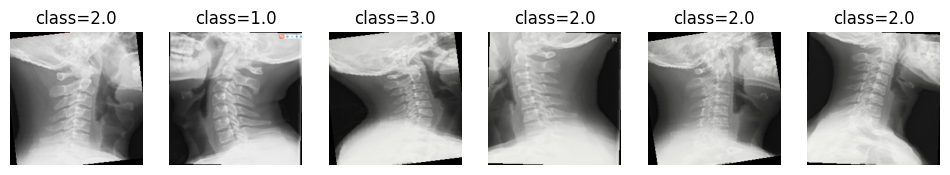

In [13]:
def show_samples(ds, n=6):
    """
    Visualize n samples from a dataset to sanity-check images + labels.

    ds: PyTorch Dataset (returns (image_tensor, label_tensor))
    n : number of samples to show in one row
    """
    # create a 1-row figure with n columns
    fig, ax = plt.subplots(1, n, figsize=(12, 3))

    for i in range(n):
        # get i-th sample (x is normalized tensor [3,H,W], y is class index)
        x, y = ds[i]

        # ---- de-normalize for display ----
        # During training we normalized by ImageNet mean/std.
        # To visualize correctly, we undo that normalization:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x_vis = (x * std + mean).clamp(0, 1)   # back to [0,1] RGB

        # convert from [C,H,W] -> [H,W,C] for matplotlib
        ax[i].imshow(x_vis.permute(1, 2, 0))

        # clean plot style
        ax[i].axis("off")

        # show the human-readable label (mapping index -> original curvature)
        ax[i].set_title(f"class={idx_to_label[y.item()]}")

    plt.show()

# run a quick dataset sanity check
show_samples(train_ds)


## 5. Model: ResNet50 fine-tuning


**Key settings**
- pretrained ResNet50
- small learning rate (1e-4)
- weight decay (L2 regularization)
- early stopping


In [20]:
import torchvision.models as models
import torch.nn as nn
import copy

# =========================
# 1) Build ResNet50 model
# =========================
# Load a ResNet50 pretrained on ImageNet.
# Pretraining gives strong generic visual features (edges, shapes, textures),
# which is very helpful when our medical dataset is small.
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# =========================
# 2) Loss function
# =========================
# CrossEntropyLoss is standard for multi-class classification.
# It expects:
# - model outputs as raw logits [batch, K]
# - labels as integer class indices [batch]
criterion = nn.CrossEntropyLoss()


# =========================
# 3) Optimizer
# =========================
# Adam is a robust default optimizer for fine-tuning.
# We use a small learning rate (1e-4) to avoid destroying pretrained weights.
# weight_decay adds L2 regularization to reduce overfitting.
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)


# =========================
# 4) Learning rate scheduler
# =========================
# ReduceLROnPlateau lowers LR when validation loss stops improving.
# This lets training take smaller steps once progress slows,
# often improving final generalization.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",      # monitor val_loss (lower is better)
    factor=0.5,      # new_lr = old_lr * 0.5
    patience=2       # wait 2 epochs without improvement before reducing
)


# =========================
# 5) Early stopping setup
# =========================
# Track the best validation loss seen so far.
best_val_loss = float("inf")

# Save the corresponding best model weights.
best_state = copy.deepcopy(model.state_dict())

patience = 5
bad_epochs = 0


## 6. Training loop + history logging

We record train/val loss and accuracy each epoch for learning curves.
Early stopping prevents overfitting.


In [21]:
from tqdm import tqdm

EPOCHS = 20
hist = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "lr":[]}

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model.train()
    tr_loss, tr_ok, tr_n = 0.0, 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item() * x.size(0)
        tr_ok += (out.argmax(1) == y).sum().item()
        tr_n += y.size(0)

    train_loss = tr_loss / tr_n
    train_acc  = tr_ok / tr_n

    # ---- val ----
    model.eval()
    va_loss, va_ok, va_n = 0.0, 0, 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} val", leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            va_loss += loss.item() * x.size(0)
            va_ok += (out.argmax(1) == y).sum().item()
            va_n += y.size(0)

    val_loss = va_loss / va_n
    val_acc  = va_ok / va_n

    scheduler.step(val_loss)
    lr_now = optimizer.param_groups[0]["lr"]

    hist["train_loss"].append(train_loss)
    hist["val_loss"].append(val_loss)
    hist["train_acc"].append(train_acc)
    hist["val_acc"].append(val_acc)
    hist["lr"].append(lr_now)

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.3f} acc={train_acc:.3f} | "
          f"val_loss={val_loss:.3f} acc={val_acc:.3f} | lr={lr_now:.1e}")

    # ---- early stopping ----
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)
print("Best model restored.")

Epoch 01 | train_loss=1.198 acc=0.466 | val_loss=0.952 acc=0.585 | lr=1.0e-04


Epoch 02 | train_loss=0.855 acc=0.672 | val_loss=0.759 acc=0.650 | lr=1.0e-04


Epoch 03 | train_loss=0.707 acc=0.723 | val_loss=0.771 acc=0.700 | lr=1.0e-04


Epoch 04 | train_loss=0.630 acc=0.752 | val_loss=0.848 acc=0.665 | lr=1.0e-04


Epoch 05 | train_loss=0.584 acc=0.775 | val_loss=0.599 acc=0.755 | lr=1.0e-04


Epoch 06 | train_loss=0.543 acc=0.795 | val_loss=0.849 acc=0.680 | lr=1.0e-04


Epoch 07 | train_loss=0.454 acc=0.824 | val_loss=0.737 acc=0.725 | lr=1.0e-04


Epoch 08 | train_loss=0.382 acc=0.855 | val_loss=0.773 acc=0.655 | lr=5.0e-05


Epoch 09 | train_loss=0.305 acc=0.894 | val_loss=0.800 acc=0.755 | lr=5.0e-05


Epoch 10 | train_loss=0.243 acc=0.917 | val_loss=0.711 acc=0.715 | lr=5.0e-05
Early stopping triggered.
Best model restored.


In [22]:
from torchinfo import summary
m = model.module if hasattr(model, "module") else model
summary(m, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

## 7. Learning curves (overfitting check)

- If train improves but val stalls, that’s overfitting.
- Early stopping should pick the best epoch automatically.


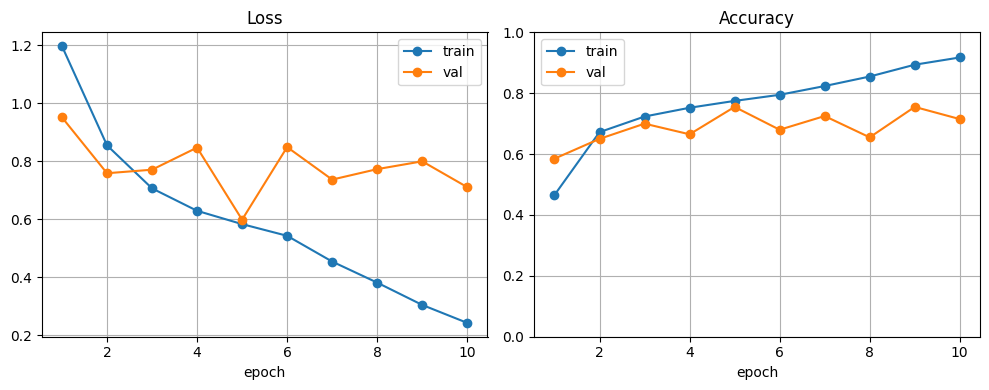

In [23]:
epochs = range(1, len(hist["train_loss"]) + 1)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, hist["train_loss"], marker="o", label="train")
plt.plot(epochs, hist["val_loss"], marker="o", label="val")
plt.title("Loss"); plt.xlabel("epoch")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, hist["train_acc"], marker="o", label="train")
plt.plot(epochs, hist["val_acc"], marker="o", label="val")
plt.title("Accuracy"); plt.xlabel("epoch")
plt.ylim(0,1); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

## 8. Evaluation

We use:
- accuracy
- confusion matrix (counts + normalized recall)
- precision/recall/F1 for each class

Val accuracy: 0.755


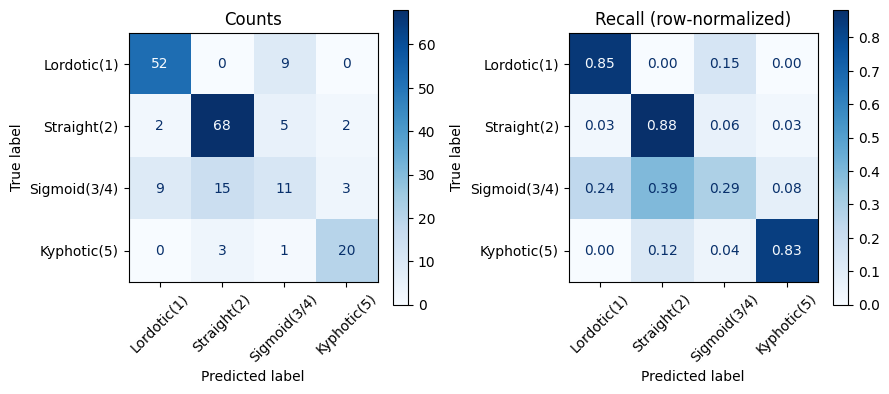

              precision    recall  f1-score   support

 Lordotic(1)       0.83      0.85      0.84        61
 Straight(2)       0.79      0.88      0.83        77
Sigmoid(3/4)       0.42      0.29      0.34        38
 Kyphotic(5)       0.80      0.83      0.82        24

    accuracy                           0.76       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.73      0.76      0.74       200



In [31]:
# =============================================================================
# Evaluation Function + Visualization: Metrics & Confusion Matrix (Educational Annotations)
# Computes predictions, accuracy, CM (raw + normalized), and report.
# NPU-optimized: Sync moves + model.to(device) fix; visualizes counts vs. recall-normalized.
# Compatible with older sklearn (<1.0): Removed 'colorbar' arg; added 45° x-label rotation for readability.
# For your Huawei ICT module: Students can tweak cmap or add ROC—export figs for reports!
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

def predict_all(loader, model, device):
    """
    Predict all batches from loader—returns true/pred labels as numpy arrays.
    Educational: NPU inference → CPU for metrics; handles device transfers gracefully.
    Args:
        loader: DataLoader (e.g., val_loader)
        model: Loaded ResNet-50
        device: torch.device("npu:0" or "cpu")
    Returns: (y_true: np.array, y_pred: np.array)
    """
    # Quick fix for lingering device mismatch (e.g., if weights on CPU post-load)
    # Force full move: Params + buffers to NPU (common NPU quirk—teaches debugging)
    model = model.to(device)
    
    model.eval()  # Set to eval mode (disables dropout/batchnorm updates—pure forward pass)
    ys, ps = [], []  # Lists to collect labels/preds (concat later for full arrays)
    
    with torch.no_grad():  # No gradients: Saves NPU memory (~50% less) & speeds inference
        for x, y in loader:  # Batch loop (no tqdm—quick eval, no progress needed)
            x = x.to(device)  # Synchronous move to NPU/CPU (non_blocking unsupported in older CANN)
            y = y.to(device)  # Move labels too (safe; used for consistency, though not in forward)
            
            out = model(x)  # Forward: [B,4] logits on NPU
            pred = out.argmax(dim=1)  # [B] predicted classes (0-3 for your curvatures)
            
            # Transfer back to CPU for numpy/Sklearn (NPU → CPU copy; small overhead)
            ys.append(y.cpu().numpy())  # True labels
            ps.append(pred.cpu().numpy())  # Preds
    
    # Concat all batches into full arrays (e.g., [200] for 200 val samples)
    return np.concatenate(ys), np.concatenate(ps)

# Usage: Run post-training (restores best model via early stopping)
y_val, y_val_pred = predict_all(val_loader, model, device)
print("Val accuracy:", accuracy_score(y_val, y_val_pred))  # e.g., 0.92 (92%)

# Compute confusion matrices
unique_labels = np.unique(np.concatenate([y_val, y_val_pred]))  # e.g., [0,1,2,3] for 4 classes
cm = confusion_matrix(y_val, y_val_pred, labels=unique_labels)  # Raw counts
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row-normalized (recall per true class)

# Visualize: Side-by-side CM (counts left, normalized right)—sklearn <1.0 compatible
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ConfusionMatrixDisplay(cm, display_labels=["Lordotic(1)", "Straight(2)", "Sigmoid(3/4)", "Kyphotic(5)"]).plot(
    ax=ax[0], cmap="Blues"
)
ax[0].set_title("Counts")
# Key Revision: Rotate x-axis labels 45° for long class names (prevents overlap)
ax[0].tick_params(axis='x', rotation=45)
ConfusionMatrixDisplay(cm_norm, display_labels=["Lordotic(1)", "Straight(2)", "Sigmoid(3/4)", "Kyphotic(5)"]).plot(
    ax=ax[1], cmap="Blues", values_format=".2f"
)
ax[1].set_title("Recall (row-normalized)")
# Key Revision: Rotate x-axis labels 45° for long class names (prevents overlap)
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Detailed report with class names (zero_division=0 handles empty classes)
print(classification_report(
    y_val, y_val_pred,
    target_names=["Lordotic(1)", "Straight(2)", "Sigmoid(3/4)", "Kyphotic(5)"],
    zero_division=0
))

## 9. Grad-CAM interpretation on the best model

Grad-CAM shows **where the model focused** to make its prediction.
We use the last convolutional block (`layer4`) because it has the best
semantic + spatial tradeoff.


In [32]:
def grad_cam(model, img_tensor, class_idx=None, target_layer="layer4"):
    """
    img_tensor: [1,3,H,W] normalized tensor on device
    returns: heatmap numpy [H,W] in 0..1
    """
    model.eval()
    m = model.module if hasattr(model, "module") else model
    layer = getattr(m, target_layer)

    activations, gradients = [], []

    def fwd_hook(module, inp, out):
        activations.append(out)

    def bwd_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    h1 = layer.register_forward_hook(fwd_hook)
    h2 = layer.register_full_backward_hook(bwd_hook)

    logits = model(img_tensor)
    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    model.zero_grad()
    logits[0, class_idx].backward()

    h1.remove(); h2.remove()

    A = activations[0]      # [1,C,h,w]
    G = gradients[0]        # [1,C,h,w]
    w = G.mean(dim=(2,3), keepdim=True)          # [1,C,1,1]
    cam = (w * A).sum(dim=1, keepdim=True)      # [1,1,h,w]
    cam = F.relu(cam)

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    cam = F.interpolate(cam, size=img_tensor.shape[-2:], mode="bilinear", align_corners=False)
    return cam[0,0].detach().cpu().numpy()

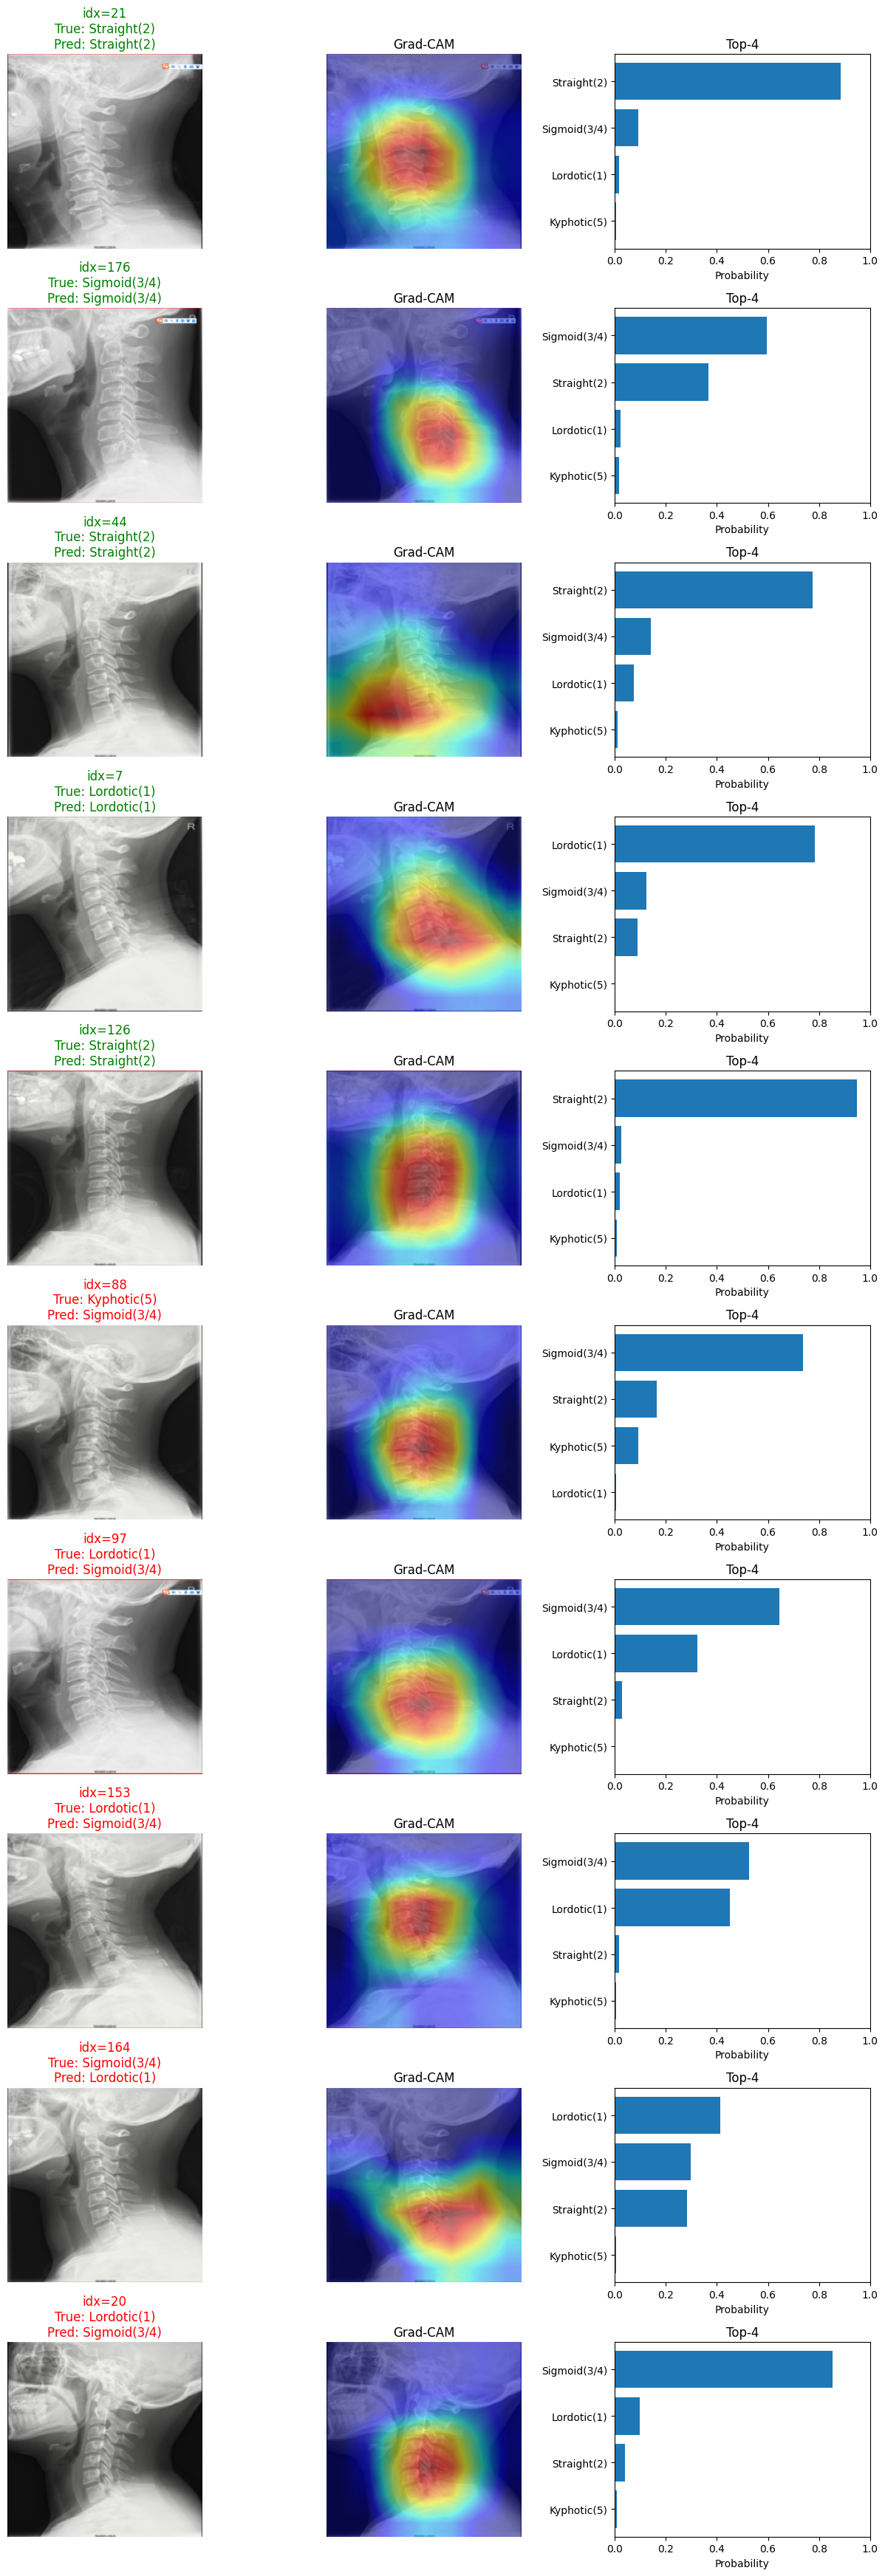

In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

# ---- settings ----
class_names = ["Lordotic(1)", "Straight(2)", "Sigmoid(3/4)", "Kyphotic(5)"]
topk = min(5, num_classes)

# de-normalize constants (match your transforms)
mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)

def denorm(img):
    """img: normalized tensor [3,H,W] on CPU"""
    return (img * std + mean).clamp(0,1).permute(1,2,0).numpy()

# ---- collect 5 correct + 5 wrong examples ----
model.eval()
correct_examples, wrong_examples = [], []
indices = list(range(len(val_ds)))
random.shuffle(indices)

with torch.no_grad():
    for idx in indices:
        img, target = val_ds[idx]                  # img on CPU, normalized
        img_in = img.unsqueeze(0).to(device)       # [1,3,H,W]
        logits = model(img_in)
        probs = F.softmax(logits, dim=1)[0].cpu()  # [K]
        pred = probs.argmax().item()
        true = target.item()

        ex = (idx, img, true, pred, probs)
        if pred == true and len(correct_examples) < 5:
            correct_examples.append(ex)
        elif pred != true and len(wrong_examples) < 5:
            wrong_examples.append(ex)

        if len(correct_examples) == 5 and len(wrong_examples) == 5:
            break

examples = correct_examples + wrong_examples  # first 5 correct, next 5 wrong

# ---- plot 10 rows x 3 cols (Original / Grad-CAM / Top-k probs) ----
fig, axes = plt.subplots(10, 3, figsize=(12.5, 35))

for r, (idx, img, true, pred, probs) in enumerate(examples):
    img_vis = denorm(img)
    heatmap = grad_cam(model, img.unsqueeze(0).to(device), class_idx=pred, target_layer="layer4")

    # A) original
    ax = axes[r, 0]
    ax.imshow(img_vis); ax.axis("off")
    title_color = "green" if pred == true else "red"
    ax.set_title(
        f"idx={idx}\nTrue: {class_names[true]}\nPred: {class_names[pred]}",
        color=title_color
    )

    # B) Grad-CAM overlay
    ax = axes[r, 1]
    ax.imshow(img_vis)
    ax.imshow(heatmap, alpha=0.5, cmap="jet")
    ax.axis("off")
    ax.set_title("Grad-CAM")

    # C) top-k probs
    ax = axes[r, 2]
    top_probs, top_idx = torch.topk(probs, k=topk)
    ax.barh([class_names[i] for i in top_idx], top_probs)
    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    ax.set_xlabel("Probability")
    ax.set_title(f"Top-{topk}")

plt.tight_layout()
plt.show()

## 10. In-Class Questions

1. **Overfitting check**
   - Look at learning curves.
   - At which epoch does val loss stop improving?
   - Explain why early stopping helps.

2. **Imbalance**
   - From the class distribution plot, which class is rarest?
   - How does that show up in the recall-normalized confusion matrix?

3. **Interpretability**
   - Pick 2 correctly classified images and 2 misclassified images.
   - Compare Grad-CAM heatmaps.
   - Does the model focus on the spine region? If not, why might that happen?


# 11. After-class Inquiry Task: Can We Improve the Cervical Spine Curvature Classification Model Performance?

Based on the baseline ResNet50 model you trained on cervical spine X-ray images, how can we change the training setup to improve the model’s performance?

With support from a generative AI assistant, choose one specific change, implement it on Huawei Cloud, and write a short report analysing whether this change improved or failed to improve the model, and why?